In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)
import itertools
from functools import partial
from collections import defaultdict, Counter
import numpy as np
import geopandas as gpd
from typing import Set, Tuple, List, Dict, Optional
import igraph
import random
import logging
from pathlib import Path
from pickle import load
import time
import networkx as nx
from zipfile import ZipFile
import os
import pyogrio
import dyntapy
from sklearn.neighbors import BallTree
import warnings
# requires local installation of ireiat package using 
from ireiat.util.cacheable import CACHE_PATH

# What this notebook does (or is meant to do) [WIP]

We solve a traffic assignment problem using dyntapy for a subset of O-Ds. To do this, we:

1. Make a transport network with the right attributes for algorithm B
    * Parse the FAF5 links data into a basic highway network
       * Free flow speed [miles/hour]?
       * Capacity (!) [tons/hour]? <-- currently pretty crude
       * Length [miles]
       * Lanes [count] <-- does not seem to matter for algorithm B
    * Do some checks on connectivity for use with algorithm B
    * Serialize that network
5. Make an OD graph between counties with the right connectors
    * Take an (optional) subset of the county-county OD flows to create an OD graph
    * Pick the number of connectors and the location of connectors within each county
    * Create an OD graph with the right attributes (including turns! excluduing turns leads to problems)
    * Serialize the result
9. Solve a static assignment problem and save the results
    * Load the serialized highway network
    * Add the connectors to the highway network
    * Relabel the graph
    * Create a StaticAssignment
    * Solve the traffic assignment problem using Algorithm B

In [3]:
round_to_digits = partial(round,ndigits=6) #helper function to standardize lat long precision

### Make a transport network with the right attributes for algorithm B

In [2]:
%%time
target_path = CACHE_PATH / 'data/raw/fa5_highway_links.zip'
# note pyogrio provides like a gajillion time speedup when reading big .shp files (11s vs. 326s with geopandas)
faf5_links_gdf = pyogrio.read_dataframe(target_path, use_arrow=True)

CPU times: total: 10.2 s
Wall time: 10.2 s


In [4]:
%%time
faf5_links_gdf = faf5_links_gdf.to_crs("EPSG:4326")

CPU times: total: 3.56 s
Wall time: 3.57 s


In [5]:
subset_faf5_links_gdf = faf5_links_gdf #.loc[~faf5_links_gdf['state'].isin(['AK','HI'])]

In [6]:
# some crude shorthand to figure out capacity
EXPECTED_TONS_PER_TRUCK = 40
EXPECTED_FEET_PER_TRUCK = 72
EXPECTED_SPACING_PER_TRUCK_FOR_FREE_FLOW = EXPECTED_FEET_PER_TRUCK
FEET_PER_MILE = 5280
DEFAULT_CAPACITY = 100000

In [7]:
def generate_graph(link_df, prohibited_node_lat_longs: Set=None):
    """ Constructs a new graph based on link data in link_df, excluding (if specified) prohibited nodes and edges that touch those prohibited nodes"""
    prohibited_node_lat_longs = prohibited_node_lat_longs or set()
    nx_highway_graph = nx.DiGraph()
    node_idx_dict: Dict[Tuple[float,float],int] = dict()
    node_idx_counter = 0
    edge_idx_counter = 0
    for row in link_df.itertuples():
        # get the origin and destination identifiers (the nodes)
        origin_longitude, origin_latitude = map(round_to_digits,  row.geometry.coords[0])
        destination_longitude, destination_latitude = map(round_to_digits,  row.geometry.coords[-1])

        # skip any prohibited nodes
        if (origin_latitude,origin_longitude) in prohibited_node_lat_longs or (destination_latitude, destination_longitude) in prohibited_node_lat_longs:
            continue
    
        # add the node indices to the dictionary if they don't exist
        if (origin_latitude,origin_longitude) not in node_idx_dict:
            node_idx_dict[(origin_latitude,origin_longitude)] = node_idx_counter
            node_idx_counter +=1
        if (destination_latitude, destination_longitude) not in node_idx_dict:
            node_idx_dict[(destination_latitude,destination_longitude)] = node_idx_counter
            node_idx_counter +=1
    
        origin_node_idx = node_idx_dict[(origin_latitude,origin_longitude)]
        destination_node_idx = node_idx_dict[(destination_latitude,destination_longitude)]
    
        # add the nodes with the right attributes to be used by dyntapy
        nx_highway_graph.add_node(origin_node_idx, 
                                  x_coord=origin_longitude, 
                                  y_coord=origin_latitude)
        nx_highway_graph.add_node(destination_node_idx, 
                                  x_coord=destination_longitude, 
                                  y_coord=destination_latitude)
    
        # add the edges with the right attributes to be used by dyntapy
        # ‘from_node_id’, ‘to_node_id’, ‘link_id’, ‘lanes’, ‘capacity’, ‘length’, ‘free_speed’
        length_miles = row.length if row.length!=0 else 0.1
        ab_lanes = 1 if (np.isnan(row.ab_lanes) or row.ab_lanes<1) else row.ab_lanes # many links have NaN or 0 lanes
        ba_lanes = 1 if (np.isnan(row.ba_lanes) or row.ba_lanes<1) else row.ba_lanes
    
        # TODO(NP) figure out free flow time for BA flows - i'm lazy
        ab_free_flow_time_hrs = length_miles/row.ab_finalsp
        count_of_trucks_on_the_link = int(length_miles*FEET_PER_MILE/(EXPECTED_FEET_PER_TRUCK+EXPECTED_SPACING_PER_TRUCK_FOR_FREE_FLOW))
        capacity_tons_per_hr = EXPECTED_TONS_PER_TRUCK*count_of_trucks_on_the_link/ab_free_flow_time_hrs
        ab_edge = {
            'u_of_edge':origin_node_idx, 
            'v_of_edge':destination_node_idx,
            'from_node_id':origin_node_idx, 
            'to_node_id':destination_node_idx,
            'lanes':ab_lanes,
            'length':length_miles,
            'free_speed':row.ab_finalsp, # still not sure of this
            'capacity':max(ab_lanes*capacity_tons_per_hr,DEFAULT_CAPACITY)
        }
        ba_edge = {
            'u_of_edge':destination_node_idx, 
            'v_of_edge':origin_node_idx,
            'from_node_id':destination_node_idx, 
            'to_node_id':origin_node_idx,
            'lanes':ba_lanes,
            'length':length_miles,
            'free_speed':row.ba_finalsp, # still not sure of this
            'capacity':max(ba_lanes*capacity_tons_per_hr,DEFAULT_CAPACITY)
        }
        
        if row.dir==1: # A-> B only
            ab_edge["link_id"]=edge_idx_counter
            nx_highway_graph.add_edge(**ab_edge)
            edge_idx_counter += 1
    
            # create a fictitious edge - debatable whether we should do this
            ba_edge["link_id"]=edge_idx_counter
            ba_edge['lanes'] = 1
            ba_edge['free_speed'] = 0.1
            ba_edge['capacity'] = DEFAULT_CAPACITY
            nx_highway_graph.add_edge(**ba_edge)
            edge_idx_counter += 1
        
        elif row.dir==-1: # B->A only
            ba_edge["link_id"]=edge_idx_counter
            nx_highway_graph.add_edge(**ba_edge)
            edge_idx_counter += 1
    
            # create a fictitious edge - debatable whether we should do this
            ab_edge["link_id"]=edge_idx_counter
            ab_edge['lanes'] = 1
            ab_edge['free_speed'] = 0.1
            ab_edge['capacity'] = DEFAULT_CAPACITY
            nx_highway_graph.add_edge(**ab_edge)
            edge_idx_counter += 1
        
        else:
            # add A->B
            ab_edge["link_id"]=edge_idx_counter
            nx_highway_graph.add_edge(**ab_edge)
            edge_idx_counter += 1
    
            # add B->A
            ba_edge["link_id"]=edge_idx_counter
            nx_highway_graph.add_edge(**ba_edge)
            edge_idx_counter += 1

    print(f"Nodes {node_idx_counter:,} and edges {edge_idx_counter:,}")
    return nx_highway_graph, node_idx_counter

In [8]:
%%time
nx_highway_graph, node_idx_counter = generate_graph(subset_faf5_links_gdf)

Nodes 348,495 and edges 974,788
CPU times: total: 17.3 s
Wall time: 17.4 s


In [9]:
len([x for x in nx_highway_graph.nodes if nx_highway_graph.in_degree[x]==nx_highway_graph.out_degree[x] and nx_highway_graph.in_degree[x]==1])

17437

In [10]:
print(f"Is graph strongly connected: {nx.is_strongly_connected(nx_highway_graph)}")
connected_component_lengths = [len(x) for x in nx.strongly_connected_components(nx_highway_graph)]
number_connected_components = len(connected_component_lengths)
connected_components_by_num_nodes = Counter(connected_component_lengths)
print(f"Number of strongly connected components {number_connected_components:,}")

Is graph strongly connected: False
Number of strongly connected components 169


In [11]:
biggest_connected_component_node_count = max(connected_components_by_num_nodes.keys())

In [12]:
disconnected_nodes = set(itertools.chain.from_iterable([x for x in nx.strongly_connected_components(nx_highway_graph) if len(x) != biggest_connected_component_node_count]))
connected_nodes = set(itertools.chain.from_iterable([x for x in nx.strongly_connected_components(nx_highway_graph) if len(x) == biggest_connected_component_node_count]))
disconnected_subgraph = nx_highway_graph.subgraph(disconnected_nodes)
connected_subgraph = nx_highway_graph.subgraph(connected_nodes)
disconnected_pos = {node:(long,lat) for (node, long,lat) in zip(nx.get_node_attributes(disconnected_subgraph,'x_coord').keys(), nx.get_node_attributes(disconnected_subgraph,'x_coord').values(),nx.get_node_attributes(disconnected_subgraph,'y_coord').values())}
connected_pos = {node:(long,lat) for (node, long,lat) in zip(nx.get_node_attributes(connected_subgraph,'x_coord').keys(), nx.get_node_attributes(connected_subgraph,'x_coord').values(),nx.get_node_attributes(connected_subgraph,'y_coord').values())}

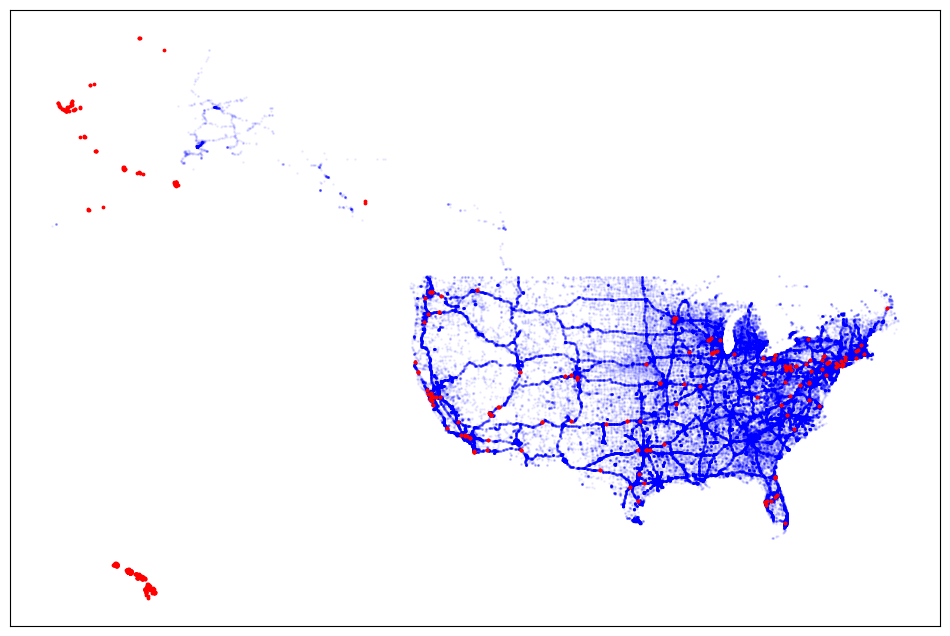

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
nx.draw_networkx_nodes(connected_subgraph,connected_pos,node_size=1,node_color='blue',ax=ax, alpha=0.05)
nx.draw_networkx_nodes(disconnected_subgraph,disconnected_pos,node_size=3,node_color='red',ax=ax)

In [13]:
# write disconnected nodes if of interest
# pd.DataFrame([idx_node_dict[k] for k in disconnected_nodes],columns=['lat','long']).to_csv('disconnected_nodes.csv')

In [14]:
print(f"Connected subgraph: nodes {len(connected_subgraph.nodes):,} and edges {len(connected_subgraph.edges):,}")
nx.is_strongly_connected(connected_subgraph)

Connected subgraph: nodes 347,167 and edges 968,903


True

In [15]:
prohibited_node_lat_longs = {(nx_highway_graph.nodes[idx]['y_coord'],nx_highway_graph.nodes[idx]['x_coord']) for idx in list(disconnected_nodes)}

In [16]:
%%time
# with a strongly connected graph, reconstruct the graph with newly labeled nodes and edges
connected_nx_highway_graph, node_idx_counter = generate_graph(subset_faf5_links_gdf, prohibited_node_lat_longs)

Nodes 347,167 and edges 971,758
CPU times: total: 16.8 s
Wall time: 16.8 s


In [17]:
nx.is_strongly_connected(connected_nx_highway_graph)

True

In [18]:
node_idx_dict = {(v['y_coord'],v['x_coord']):k for k,v in connected_nx_highway_graph.nodes.items()}
# for subsequent lookup by node id
idx_node_dict = {v:k for k,v in node_idx_dict.items()}

### Make an OD graph between counties with the right connectors

Inputs:
  * Pre-computed county-county flows (in ktons)
  * County .shp files (to get the geometry of the counties)

Outputs:
  * The location (latitude, longitude) of the connectors that will be used to attach to the transport graph (.pickle file)
  * A networkx graph with attributes formatted according to dyntapy needs to solve static assignment
    
This procedure requires us to to make assumptions on:
  * How many points in the county demand will originate from (assumed 1 in the current implementation)
  * Where in the county demand will originate from (assumed the geographic centroid in the current implementation)

We can change these calculation assumptions but will still need to generate the two outputs to solve the static assignment problem
    

In [19]:
# input 1
county_od = pd.read_parquet('../data/transformed/county_od.parquet')

In [20]:
# input 2
target_path = CACHE_PATH /  'data/raw/us_county_shp_files.zip'
county_gdf = pyogrio.read_dataframe(target_path, use_arrow=True)

In [21]:
# let's start with a small portion of the ODs to see if we can get it to work
OD_QUANTILE_THRESHOLD = .999
# OD_QUANTILE_THRESHOLD = None
if OD_QUANTILE_THRESHOLD:
    tons_threshold = county_od['tons'].quantile(OD_QUANTILE_THRESHOLD)
    subset_county_od = county_od.loc[county_od['tons'] > tons_threshold]
else:
    subset_county_od = county_od
len(subset_county_od)

9835

In [23]:
subset_county_od['tons'].describe()

count     9835.000000
mean       701.505067
std       2247.938474
min        157.402054
25%        207.254248
50%        303.169235
75%        573.807092
max      84673.970029
Name: tons, dtype: float64

In [24]:
# Now we need to figure out where in each county we want a "connector" [a location from which tons will attach to the transport graph]
# right now, we're using the "actual" geometric centroid as the "connector" location  in the county but we could refine this in the future
# based on where in the county we expect things to be originating from and/or how many "connectors" we want to have within each county
county_gdf = county_gdf.to_crs("EPSG:5070") # albers

In [25]:
county_gdf['centroid'] = county_gdf.geometry.centroid.to_crs("EPSG:4326") # in lat/long

In [26]:
%%time
# create a dict of (statefp,countyfp) => connector latitude, connector longitude [right now this is only using a SINGLE connector]
county_to_node_dict = dict()
county_to_node_idx_dict = dict()
for idx, row in enumerate(county_gdf.itertuples()):
    county_to_node_dict[(row.STATEFP,row.COUNTYFP)]=(round_to_digits(row.centroid.y), round_to_digits(row.centroid.x))
    county_to_node_idx_dict[(row.STATEFP,row.COUNTYFP)] = idx

CPU times: total: 78.1 ms
Wall time: 74 ms


In [27]:
%%time
od_graph = nx.DiGraph()
for row in subset_county_od.itertuples():
    # get the origin and destination identifiers
    origin_node, destination_node = (row.state_orig, row.county_orig), (row.state_dest, row.county_dest)

    # extract the node latitudes and longitudes and indices from pre-computed dictionaries
    origin_latitude, origin_longitude = county_to_node_dict[origin_node]
    destination_latitude, destination_longitude = county_to_node_dict[destination_node]
    origin_node_idx,destination_node_idx = county_to_node_idx_dict[origin_node], county_to_node_idx_dict[destination_node]

    # add the nodes and edges with the right attributese to be used by dyntapy
    od_graph.add_node(origin_node_idx, x_coord=origin_longitude, y_coord=origin_latitude)
    od_graph.add_node(destination_node_idx, x_coord=destination_longitude, y_coord=destination_latitude)
    od_graph.add_edge(origin_node_idx, destination_node_idx, flow=row.tons)

print(f"OD graph: num nodes ({len(od_graph.nodes):,}), edges ({len(od_graph.edges):,})")

OD graph: num nodes (1,486), edges (9,835)
CPU times: total: 31.2 ms
Wall time: 41.8 ms


In [25]:
%%time
# serialize the OD graph
nx.write_gml(od_graph, CACHE_PATH / "data/transformed/county_od_graph.gml")

CPU times: total: 328 ms
Wall time: 318 ms


In [27]:
%%time
# test that we can reload the OD graph
od_graph = nx.read_gml(CACHE_PATH / "data/transformed/county_od_graph.gml")

CPU times: total: 2.14 s
Wall time: 2.13 s


### Solve algorithm B using the highway network and the OD graph that we've previously serialized

In [28]:
centroid_x = np.array([row.centroid.x for row in county_gdf.itertuples()])
centroid_y = np.array([row.centroid.y for row in county_gdf.itertuples()])

In [29]:
# we need to find where on the highway graph to connect the centroids
# construct a ball tree based on the highway graph data
highway_node_lat_long_radians = np.deg2rad(np.array(list(node_idx_dict.keys())))
highway_node_ball_tree = BallTree(highway_node_lat_long_radians, metric='haversine')

In [30]:
# get the centroid locations
RADIUS_EARTH_MILES = 3958.8
centroid_lat_longs = [(lat,long) for lat,long in zip(centroid_y,centroid_x)]
centroid_radians = np.deg2rad(centroid_lat_longs)
distances_radians, centroid_idx_to_hwy_node_idx = highway_node_ball_tree.query(centroid_radians,k=1)
distances_miles = distances_radians.squeeze()*RADIUS_EARTH_MILES
centroid_idx_to_hwy_node_idx = centroid_idx_to_hwy_node_idx.squeeze() # make a 1-D array

# add the centroids and associated links to the highway graph
augmented_nx_highway_graph = connected_nx_highway_graph.copy()
augmented_graph_node_index_counter = node_idx_counter
DEFAULT_CONNECTOR_LANES = 10
DEFAULT_CONNECTOR_CAPACITY = 1e6
DEFAULT_CONNECTOR_SPEED = 200
DELTA_LATITUDE = 0.0001 # 11m

for (centroid_lat, centroid_long), dist, hwy_node_idx in zip(centroid_lat_longs, distances_miles, centroid_idx_to_hwy_node_idx):
    # add the centroid node
    centroid_node_idx = augmented_graph_node_index_counter
    augmented_nx_highway_graph.add_node(centroid_node_idx, x_coord=centroid_long, y_coord=centroid_lat, centroid="true")
    if (centroid_lat,centroid_long) in node_idx_dict:
        print(f"Uh-oh. Centroid of {(centroid_lat,centroid_long)} for a county is amazingly already on the highway network.")
    node_idx_dict[(centroid_lat,centroid_long)] = centroid_node_idx
    augmented_graph_node_index_counter +=1

    # add the "turn" node
    turn_node_idx = augmented_graph_node_index_counter
    turn_lat, turn_long = centroid_lat+DELTA_LATITUDE, centroid_long
    if (turn_lat,turn_long) in node_idx_dict:
        print(f"Uh-oh. Turn of {(turn_lat,turn_long)} is amazingly already on the highway network.")
    augmented_nx_highway_graph.add_node(turn_node_idx, x_coord=turn_long, y_coord=turn_lat)
    node_idx_dict[(turn_lat,turn_long)] = turn_node_idx
    augmented_graph_node_index_counter +=1

    # get where we're going to attach these things to the graph
    connected_node_latitude, connected_node_longitude = idx_node_dict[hwy_node_idx]

    # add connectors from the centroid to the turn and the turn to the highway
    CONNECTOR_DEFAULT_DICT = {
        'lanes':DEFAULT_CONNECTOR_LANES,
        'length':dist,
        'free_speed':DEFAULT_CONNECTOR_SPEED,
        'capacity':DEFAULT_CONNECTOR_CAPACITY,
        'connector':True
    }

    # note link_type=1 (source), link_type=-1 (sink)
    centroid_to_turn = {'u_of_edge': centroid_node_idx, 
                        'v_of_edge': turn_node_idx, 
                        'link_type': np.int8(1),
                        'from_node_id':centroid_node_idx, 
                        'to_node_id':turn_node_idx,
                        **CONNECTOR_DEFAULT_DICT}
    
    turn_to_centroid = {'u_of_edge': turn_node_idx, 
                        'v_of_edge': centroid_node_idx, 
                        'link_type': np.int8(-1),
                        'from_node_id':turn_node_idx, 
                        'to_node_id':centroid_node_idx,
                        **CONNECTOR_DEFAULT_DICT}
    
    turn_to_highway = {'u_of_edge': turn_node_idx, 
                       'v_of_edge': hwy_node_idx, 
                       'link_type': np.int8(1), 
                        'from_node_id':turn_node_idx, 
                        'to_node_id':hwy_node_idx,
                       **CONNECTOR_DEFAULT_DICT}
    
    highway_to_turn = {'u_of_edge': hwy_node_idx, 
                       'v_of_edge': turn_node_idx, 
                       'link_type': np.int8(-1), 
                        'from_node_id':hwy_node_idx, 
                        'to_node_id':turn_node_idx,
                       **CONNECTOR_DEFAULT_DICT}

    for some_edge in [centroid_to_turn, turn_to_centroid, turn_to_highway, highway_to_turn]:
        augmented_nx_highway_graph.add_edge(**some_edge)

In [31]:
augmented_nx_hwy_graph_relabeled = dyntapy.relabel_graph(augmented_nx_highway_graph)

In [32]:
[a for a in list(augmented_nx_hwy_graph_relabeled.nodes) if 'x_coord' not in augmented_nx_hwy_graph_relabeled.nodes[a]]

[]

In [33]:
[a for a in list(augmented_nx_hwy_graph_relabeled.edges) if augmented_nx_hwy_graph_relabeled.edges[a]['capacity'] ==0]

[]

In [34]:
%%time
sa = dyntapy.assignments.StaticAssignment(augmented_nx_hwy_graph_relabeled, od_graph)

C:\Users\nicholas.padon\AppData\Local\Programs\Python\Python311\Lib\site-packages\dyntapy\supply_data.py:456: UserWarning: Network contains very long links, up to 4705.732421875 km. Implementation has not been verified forthis type of network. calculations may yield unexpected results.
  warn(
C:\Users\nicholas.padon\AppData\Local\Programs\Python\Python311\Lib\site-packages\dyntapy\demand.py:117: UserWarning: intra-zonal traffic is ignored
  warn("intra-zonal traffic is ignored")


init passed successfully
CPU times: total: 50.3 s
Wall time: 50.6 s


In [35]:
%%time
result = sa.run(method='dial_b') # uses numba, so first run needs compilation time

AssertionError: 

# Garbage

1. Methods for stuff

* all or nothing assignment [naive "lowest" impedance path for each O-D pair. does not take into account congestion]
* sequential congestion assignment [order-dependent! not straighforwardly parallelizable. not obvious what the congestion function is...]
* probablistic assignment on top k "low impedance" candidate paths [picking candidates is hard]
* really cool convex programming problem [intractable]
    - for all flow paths between O-D, have some power (quadratic?) cost function with constraints

In [13]:
# %%time
# # 6th decimal place is 0.11m in lat/long. IF you go to greater granularity you still get the same number of nodes
# # https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude

# def map_start_end_lat_long(row):
#     """ Each LINESTRING object consists of lat/longs - and the bounds get the extreme endpoints"""
#     long_start, lat_start = map(round_to_digits,  row.geometry.coords[0])
#     long_end, lat_end = map(round_to_digits,  row.geometry.coords[-1])
#     # return (row.objectid, row.length, (lat_start, long_start), (lat_end, long_end))
#     if row.dir==1: # A-> B only
#         return [(row.objectid, row.length, row.ctfips, (lat_start, long_start), (lat_end, long_end))]
#     elif row.dir==-1: # B->A only
#         return [(row.objectid, row.length, row.ctfips, (lat_end, long_end), (lat_start, long_start))]
#     else:
#         return [(row.objectid, row.length, row.ctfips, (lat_start, long_start), (lat_end, long_end)),
#                 (row.objectid, row.length, row.ctfips, (lat_end, long_end), (lat_start, long_start))]


# # we iterate through the set of links in parallel, extracting formatted endpoints
# edge_data = list(itertools.chain.from_iterable([map_start_end_lat_long(row) for row in faf5_links_gdf.itertuples()]))
# # edge_data = [map_start_end_lat_long(row) for row in faf5_links_gdf.itertuples()]

CPU times: total: 13.6 s
Wall time: 13.6 s


In [14]:
# # create a list of county to node dicts
# county_to_node_dict = defaultdict(list)
# for obj, length, ctfips, lat_long_start, lat_long_end in edge_data:
#     if ctfips:
#         state, county = ctfips[:2], ctfips[2:]
#         county_to_node_dict[(state,county)].append(lat_long_start)
#         county_to_node_dict[(state,county)].append(lat_long_end)

In [16]:
# # from the formatted endpoints, we create unique nodes, indexed from 0
# node_set: Set[Tuple[float, float]] = {(lat,long) for record in edge_data for lat,long in record[3:]}
# node_dict: Dict[Tuple[float, float], int] = {node_lat_long: idx for idx, node_lat_long in enumerate(node_set)}
# inv_node_dict: Dict[int, Tuple[float, float]] = {v: k for k,v in node_dict.items()}

# # we then map back all the edges
# n_vertices = len(node_set)
# edge_object_ids = [obj_id for obj_id, _, _, _, _ in edge_data]
# edges = [[node_dict[start_node], node_dict[end_node]] for _, _, _, start_node, end_node in edge_data]
# edge_distances = [distance for _, distance, _, _, _ in edge_data]

# # and we create the highway graph and output it
# highway_graph = igraph.Graph(n=n_vertices, 
#                              edges=edges, 
#                              edge_attrs={'weight':edge_distances}
#                             )
# highway_graph.write_gml("../data/transformed/highway.gml")

In [17]:
# with open('../data/transformed/county_to_node_dict.pickle','wb') as fp:
#     pickle.dump(county_to_node_dict, fp)

In [18]:
# with open('../data/transformed/node_dict.pickle','wb') as fp:
#     pickle.dump(node_dict, fp)

In [ ]:
    # # add source and sink connectors
    # source_data = {
    #     'u_of_edge':node_idx_counter, 
    #     'v_of_edge':hwy_node_idx,
    #     'lanes':DEFAULT_CONNECTOR_LANES,
    #     'length':dist,
    #     'free_speed':DEFAULT_CONNECTOR_SPEED,
    #     'capacity':DEFAULT_CONNECTOR_CAPACITY,
    #     'connector':True,
    #     "link_type": np.int8(1),
    # }
    # sink_data = {
    #     'u_of_edge':hwy_node_idx, 
    #     'v_of_edge':node_idx_counter,
    #     'lanes':DEFAULT_CONNECTOR_LANES,
    #     'length':dist,
    #     'free_speed':DEFAULT_CONNECTOR_SPEED,
    #     'capacity':DEFAULT_CONNECTOR_CAPACITY,
    #     'connector':True,
    #     "link_type": np.int8(-1),
    # }

 

    
    # augmented_nx_highway_graph.add_edge(**source_data)
    # augmented_nx_highway_graph.add_edge(**sink_data)

In [ ]:
# %%time
# nx_highway_graph = nx.DiGraph()
# node_idx_dict: Dict[Tuple[float,float],int] = dict()
# node_idx_counter = 0
# edge_idx_counter = 0
# for row in subset_faf5_links_gdf.itertuples():
#     # get the origin and destination identifiers (the nodes)
#     origin_longitude, origin_latitude = map(round_to_digits,  row.geometry.coords[0])
#     destination_longitude, destination_latitude = map(round_to_digits,  row.geometry.coords[-1])

#     # add the node indices to the dictionary if they don't exist
#     if (origin_latitude,origin_longitude) not in node_idx_dict:
#         node_idx_dict[(origin_latitude,origin_longitude)] = node_idx_counter
#         node_idx_counter +=1
#     if (destination_latitude, destination_longitude) not in node_idx_dict:
#         node_idx_dict[(destination_latitude,destination_longitude)] = node_idx_counter
#         node_idx_counter +=1

#     origin_node_idx = node_idx_dict[(origin_latitude,origin_longitude)]
#     destination_node_idx = node_idx_dict[(destination_latitude,destination_longitude)]

#     # add the nodes with the right attributes to be used by dyntapy
#     nx_highway_graph.add_node(origin_node_idx, 
#                               x_coord=origin_longitude, 
#                               y_coord=origin_latitude)
#     nx_highway_graph.add_node(destination_node_idx, 
#                               x_coord=destination_longitude, 
#                               y_coord=destination_latitude)

#     # add the edges with the right attributes to be used by dyntapy
#     # ‘from_node_id’, ‘to_node_id’, ‘link_id’, ‘lanes’, ‘capacity’, ‘length’, ‘free_speed’
#     length_miles = row.length if row.length!=0 else 0.1
#     ab_lanes = 1 if (np.isnan(row.ab_lanes) or row.ab_lanes<1) else row.ab_lanes # many links have NaN or 0 lanes
#     ba_lanes = 1 if (np.isnan(row.ba_lanes) or row.ba_lanes<1) else row.ba_lanes

#     # TODO(NP) figure out free flow time for BA flows - i'm lazy
#     ab_free_flow_time_hrs = length_miles/row.ab_finalsp
#     count_of_trucks_on_the_link = int(length_miles*FEET_PER_MILE/(EXPECTED_FEET_PER_TRUCK+EXPECTED_SPACING_PER_TRUCK_FOR_FREE_FLOW))
#     capacity_tons_per_hr = EXPECTED_TONS_PER_TRUCK*count_of_trucks_on_the_link/ab_free_flow_time_hrs
#     ab_edge = {
#         'u_of_edge':origin_node_idx, 
#         'v_of_edge':destination_node_idx,
#         'from_node_id':origin_node_idx, 
#         'to_node_id':destination_node_idx,
#         'lanes':ab_lanes,
#         'length':length_miles,
#         'free_speed':row.ab_finalsp, # still not sure of this
#         'capacity':ab_lanes*capacity_tons_per_hr   
#     }
#     ba_edge = {
#         'u_of_edge':destination_node_idx, 
#         'v_of_edge':origin_node_idx,
#         'from_node_id':destination_node_idx, 
#         'to_node_id':origin_node_idx,
#         'lanes':ba_lanes,
#         'length':length_miles,
#         'free_speed':row.ba_finalsp, # still not sure of this
#         'capacity':ba_lanes*capacity_tons_per_hr   
#     }
    
#     if row.dir==1: # A-> B only
#         ab_edge["link_id"]=edge_idx_counter
#         nx_highway_graph.add_edge(**ab_edge)
#         edge_idx_counter += 1

#         # create a fictitious edge - debatable whether we should do this
#         ba_edge["link_id"]=edge_idx_counter
#         ba_edge['lanes'] = 1
#         ba_edge['free_speed'] = 1
#         ba_edge['capacity'] = 1
#         nx_highway_graph.add_edge(**ba_edge)
#         edge_idx_counter += 1
    
#     elif row.dir==-1: # B->A only
#         ba_edge["link_id"]=edge_idx_counter
#         nx_highway_graph.add_edge(**ba_edge)
#         edge_idx_counter += 1

#         # create a fictitious edge - debatable whether we should do this
#         ab_edge["link_id"]=edge_idx_counter
#         ab_edge['lanes'] = 1
#         ab_edge['free_speed'] = 1
#         ab_edge['capacity'] = 1
#         nx_highway_graph.add_edge(**ab_edge)
#         edge_idx_counter += 1
    
#     else:
#         # add A->B
#         ab_edge["link_id"]=edge_idx_counter
#         nx_highway_graph.add_edge(**ab_edge)
#         edge_idx_counter += 1

#         # add B->A
#         ba_edge["link_id"]=edge_idx_counter
#         nx_highway_graph.add_edge(**ba_edge)
#         edge_idx_counter += 1

# print(f"Nodes {node_idx_counter:,} and edges {edge_idx_counter:,}")